# Attempt to classify copulation vs non-copulation sessions based on song features

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from disp import set_font_size

cc = np.concatenate

FPS = 30.03

In [2]:
df = pd.read_csv('data/simple/c_song_f_behav.csv')
df

,ID,FRAME,T,Q,S,P,F,FFV,FFA,FLS,FRS
0,0,0,0.000000,1,0,0,0,0.231,0.0000,0.159,0.077
1,0,1,0.033300,1,0,0,0,0.314,0.0385,0.025,0.044
2,0,2,0.066600,1,0,0,0,0.308,0.0025,0.029,0.011
3,0,3,0.099900,1,0,0,0,0.319,0.0020,0.016,0.016
4,0,4,0.133200,1,0,0,0,0.312,-0.0315,0.030,0.002
...,...,...,...,...,...,...,...,...,...,...,...
4978565,275,27100,902.430902,1,0,0,0,0.217,0.0280,0.029,0.058
4978566,275,27101,902.464202,1,0,0,0,0.210,-0.1045,0.138,0.322
4978567,275,27102,902.497502,1,0,0,0,0.008,-0.0910,0.034,0.260
4978568,275,27103,902.530803,1,0,0,0,0.028,0.0695,0.010,0.090


In [3]:
# sort trials by time till copulation
n_trial = np.max(df.ID) + 1
dfs_trial = [df[df.ID == i] for i in range(n_trial)]
dfs_trial = sorted(dfs_trial, key=len)

In [4]:
# trial lengths and copulation-triggered frames for time window selection
tr_lens = np.array([len(df_trial)-1 for df_trial in dfs_trial])

# class labels (copulation = 1, non-copulation = 0)
ys = cc([np.repeat(1, n_trial//2), np.repeat(0, n_trial//2)])

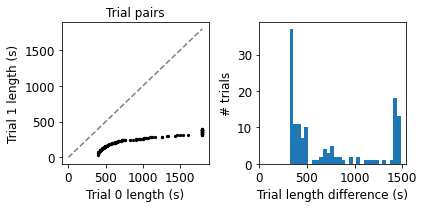

In [5]:
fig, axs = plt.subplots(1, 2, figsize=(6, 3), tight_layout=True)
axs[0].scatter(tr_lens[n_trial//2:]/FPS, tr_lens[:n_trial//2]/FPS, c='k', s=5)
axs[0].plot([0, 1800], [0, 1800], c='gray', ls='--')
axs[0].set_xlabel('Trial 0 length (s)')
axs[0].set_ylabel('Trial 1 length (s)')
axs[0].set_title('Trial pairs')

axs[1].hist((tr_lens[n_trial//2:] - tr_lens[:n_trial//2])/FPS, bins=30)
axs[1].set_xlim(left=0)
axs[1].set_xlabel('Trial length difference (s)')
axs[1].set_ylabel('# trials')

set_font_size(axs, 12)

In [6]:
# get predictors as matrices for each trial
T = 10
IT = int(round(T*FPS))

trig_frms = cc([tr_lens[:n_trial//2], tr_lens[:n_trial//2]])

predictor_dfs = [df_trial[trig_frm-IT:trig_frm][['S', 'P', 'F']] for df_trial, trig_frm in zip(dfs_trial, trig_frms)]
predictor_mats = np.array([np.array([predictor_df['S'], predictor_df['P'] | predictor_df['F']]) for predictor_df in predictor_dfs], dtype=object)  # combine slow and fast pulses

False positive rate at max accuracy threshold: 0.2463768115942029


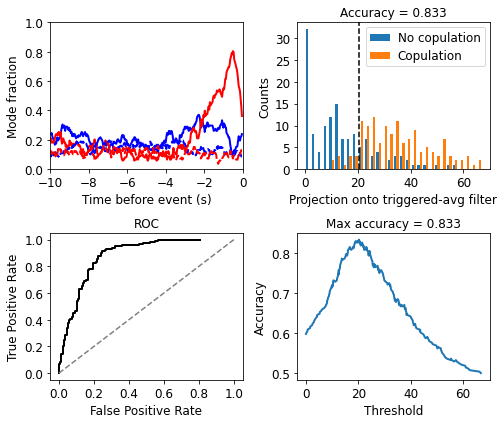

In [7]:
t = np.arange(-IT, 0)/FPS

mean_sin_pre_cpln = np.mean([predictor_mat[0] for predictor_mat in predictor_mats[ys==1]], axis=0)
mean_pls_pre_cpln = np.mean([predictor_mat[1] for predictor_mat in predictor_mats[ys==1]], axis=0)

mean_sin_pre_non_cpln = np.mean([predictor_mat[0] for predictor_mat in predictor_mats[ys==0]], axis=0)
mean_pls_pre_non_cpln = np.mean([predictor_mat[1] for predictor_mat in predictor_mats[ys==0]], axis=0)

fig, axs = plt.subplots(2, 2, figsize=(7, 6), tight_layout=True)
axs[0, 0].plot(t, mean_sin_pre_cpln, c='b', lw=2)
axs[0, 0].plot(t, mean_pls_pre_cpln, c='r', lw=2)

axs[0, 0].plot(t, mean_sin_pre_non_cpln, c='b', lw=2, ls='--')
axs[0, 0].plot(t, mean_pls_pre_non_cpln, c='r', lw=2, ls='--')
axs[0, 0].set_xlim(-T, 0)
axs[0, 0].set_ylim(0, 1)
axs[0, 0].set_xlabel('Time before event (s)')
axs[0, 0].set_ylabel('Mode fraction')

h_cpln_triggered = np.array([mean_sin_pre_cpln, mean_pls_pre_cpln])
h_cpln_triggered /= np.sqrt(np.sum(h_cpln_triggered**2)/FPS)

projs_h_cpln_triggered = np.array([np.sum(predictor_mat*h_cpln_triggered) for predictor_mat in predictor_mats])
axs[0, 1].hist(np.transpose([projs_h_cpln_triggered[ys==0], projs_h_cpln_triggered[ys==1]]), bins=30)
axs[0, 1].set_xlabel('Projection onto triggered-avg filter')
axs[0, 1].set_ylabel('Counts')
axs[0, 1].legend(['No copulation', 'Copulation'])

# plot ROC and accuracy
th_sweep = np.array(sorted(projs_h_cpln_triggered))
tp = np.nan * np.zeros(th_sweep.shape)
tn = np.nan * np.zeros(th_sweep.shape)
fp = np.nan * np.zeros(th_sweep.shape)
fn = np.nan * np.zeros(th_sweep.shape)
acc = np.nan * np.zeros(th_sweep.shape)

for cth, th in enumerate(th_sweep):
    y_hat = projs_h_cpln_triggered > th
    tp[cth] = np.mean((ys==1) & (y_hat==1))/np.mean(ys==1)
    tn[cth] = np.mean((ys==0) & (y_hat==0))/np.mean(ys==0)
    fp[cth] = np.mean((ys==0) & (y_hat==1))/np.mean(ys==0)
    fn[cth] = np.mean((ys==1) & (y_hat==0))/np.mean(ys==1)
    acc[cth] = np.mean(ys==y_hat)
    
axs[1, 0].plot(fp, tp, c='k', lw=2)
axs[1, 0].plot([0, 1], [0, 1], c='gray', ls='--')
axs[1, 0].set_xlabel('False Positive Rate')
axs[1, 0].set_ylabel('True Positive Rate')
axs[1, 0].set_title('ROC')

axs[1, 1].plot(th_sweep, acc, lw=2)
axs[1, 1].set_xlabel('Threshold')
axs[1, 1].set_ylabel('Accuracy')
axs[1, 1].set_title(f'Max accuracy = {acc.max():.3f}')

th_best = th_sweep[np.argmax(acc)]
axs[0, 1].axvline(th_best, color='k', ls='--')
axs[0, 1].set_title(f'Accuracy = {acc.max():.3f}')
set_font_size(axs, 12)

print('False positive rate at max accuracy threshold:', fp[np.argmax(acc)])

Calc accuracy on held out data using triggered-average filter

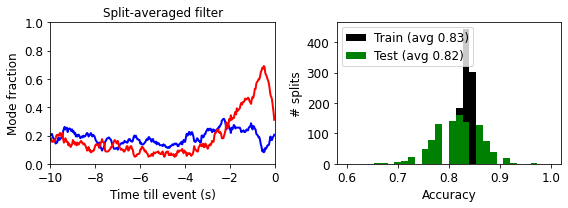

In [8]:
frc_train = .8
n_train_per_class = int(round(frc_train*n_trial/2))
n_test_per_class = n_trial//2 - n_train_per_class

n_split = 1000

h_trig_avgs = []
accs_train = []
accs_test = []

for csplit in range(n_split):
    idxs_1 = np.random.permutation(n_trial//2)  # training/test idxs for y=1 (copulation) trials
    train_idxs = cc([idxs_1[:n_train_per_class], idxs_1[:n_train_per_class]+n_trial//2])
    test_idxs = cc([idxs_1[-n_test_per_class:], idxs_1[-n_test_per_class:]+n_trial//2])
    assert not any([idx in test_idxs for idx in train_idxs])
    assert not any([idx in train_idxs for idx in test_idxs])
    
    predictor_mats_train = predictor_mats[train_idxs, :, :]
    ys_train = ys[train_idxs]
    
    mean_sin_pre_cpln = np.mean([predictor_mat[0] for predictor_mat in predictor_mats_train[ys_train==1]], axis=0)
    mean_pls_pre_cpln = np.mean([predictor_mat[1] for predictor_mat in predictor_mats_train[ys_train==1]], axis=0)
    
    h_cpln_triggered_train = np.array([mean_sin_pre_cpln, mean_pls_pre_cpln])
    h_cpln_triggered_train /= np.sqrt(np.sum(h_cpln_triggered_train**2)/FPS)
    
    h_trig_avgs.append(h_cpln_triggered_train.copy())
    
    # get training accuracy
    projs_h_cpln_triggered_train = np.array([np.sum(predictor_mat*h_cpln_triggered_train) for predictor_mat in predictor_mats_train])
    
    th_sweep = np.array(sorted(projs_h_cpln_triggered_train))
    acc = np.nan * np.zeros(th_sweep.shape)

    for cth, th in enumerate(th_sweep):
        y_hat_train = projs_h_cpln_triggered_train > th
        acc[cth] = np.mean(ys_train==y_hat_train)

    accs_train.append(acc.max())
    
    # get threshold for max accuracy
    th = th_sweep[np.argmax(acc)]
    
    # get test accuracy
    predictor_mats_test = predictor_mats[test_idxs, :, :]
    ys_test = ys[test_idxs]
    
    projs_h_cpln_triggered_test = np.array([np.sum(predictor_mat*h_cpln_triggered_train) for predictor_mat in predictor_mats_test])
    y_hat_test = projs_h_cpln_triggered_test > th
    accs_test.append(np.mean(ys_test==y_hat_test))

h_trig_avgs = np.array(h_trig_avgs)

fig, axs = plt.subplots(1, 2, figsize=(8, 3), tight_layout=True)

axs[0].plot(t, np.mean(h_trig_avgs, 0)[0], c='b', lw=2)
axs[0].plot(t, np.mean(h_trig_avgs, 0)[1], c='r', lw=2)
axs[0].set_xlim(-10, 0)
axs[0].set_ylim(0, 1)
axs[0].set_xlabel('Time till event (s)')
axs[0].set_ylabel('Mode fraction')
axs[0].set_title('Split-averaged filter')

axs[1].hist(accs_train, bins=np.linspace(.6, 1, 31), color='k')
axs[1].hist(accs_test, bins=np.linspace(.6, 1, 31), color='g')
axs[1].set_xlabel('Accuracy')
axs[1].set_ylabel('# splits')
axs[1].legend([f'Train (avg {np.mean(accs_train):.2f})', f'Test (avg {np.mean(accs_test):.2f})'], loc='upper left')
set_font_size(axs, 12)